# Libraries & Custom functions

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Ignore UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
############################################################### Functions for Part 2 a) ###############################################################

def BCE_Loss_RNN(y_true, y_hat):
    
    loss_1 = -1 * (y_true[0] * torch.log(y_hat[0]) + (1 - y_true[0]) * torch.log(1 - y_hat[0]))
    loss_2 = -1 * (y_true[1] * torch.log(y_hat[1]) + (1 - y_true[1]) * torch.log(1 - y_hat[1]))

    return loss_1 + loss_2, loss_1, loss_2


def ForwardPropagation(input_values, hidden_states, initial_state, v, bias, weights):

    hidden_states[0] = torch.matmul(input_values[0], weights.T) + v * initial_state + bias
    hidden_states[1] = torch.matmul(input_values[1], weights.T) + v * hidden_states[0] + bias

    y_hat = F.sigmoid(hidden_states)
    
    return y_hat


def BackPropagation(input_values, hidden_states, initial_state, v, y_true, y_hat):
    # Backpropagation for time step t=2

    # Compute gradient of loss with respect to output at t=2
    dL2_dh2 = -1 * (y_true[1] / y_hat[1] - (1 - y_true[1]) / (1 - y_hat[1]))
    # Compute gradient of output with respect to pre-activation at t=2
    dL2_da2 = dL2_dh2 * (y_hat[1] * (1 - y_hat[1]))
    # Compute gradient of pre-activation with respect to weights at t=2
    dL2_dW2 = dL2_da2 * input_values[1]
    # Compute gradient of pre-activation with respect to previous hidden state at t=2
    dL2_dv2 = dL2_da2 * hidden_states[0]
    # Compute gradient of pre-activation with respect to bias at t=2
    dL2_db2 = dL2_da2 * 1
    # Compute gradient of pre-activation with respect to hidden state at t=1
    dL2_dh1 = dL2_da2 * v
    # Compute gradient of hidden state with respect to pre-activation at t=1
    dL2_da1 = dL2_dh1 * (y_hat[0] * (1 - y_hat[0]))
    # Compute gradient of pre-activation with respect to weights at t=1
    dL2_dW1 = dL2_da1 * input_values[0]
    # Compute gradient of pre-activation with respect to initial hidden state
    dL2_dv1 = dL2_da1 * initial_state
    # Compute gradient of pre-activation with respect to bias at t=1
    dL2_db1 = dL2_da1 * 1
    # Accumulate gradients for time step t=2
    dL2_dW = dL2_dW2 + dL2_dW1
    dL2_dV = dL2_dv2 + dL2_dv1
    dL2_dB = dL2_db2 + dL2_db1

    # Backpropagation for time step t=1

    # Compute gradient of loss with respect to output at t=1
    dL1_dh1 = -1 * (y_true[0] / y_hat[0] - (1 - y_true[0]) / (1 - y_hat[0]))
    # Compute gradient of output with respect to pre-activation at t=1
    dL1_da1 = dL1_dh1 * (y_hat[0] * (1 - y_hat[0]))
    # Compute gradient of pre-activation with respect to weights at t=1
    dL1_dW1 = dL1_da1 * input_values[0]
    # Compute gradient of pre-activation with respect to initial hidden state
    dL1_dv1 = dL1_da1 * initial_state
    # Compute gradient of pre-activation with respect to bias at t=1
    dL1_db1 = dL1_da1 * 1
    # Accumulate gradients for time step t=1
    dL1_dW = dL1_dW1
    dL1_dV = dL1_dv1
    dL1_dB = dL1_db1

    # Overall gradients

    # Sum gradients for both time steps
    dL_dW = dL2_dW + dL1_dW
    dL_dV = dL2_dV + dL1_dV
    dL_dB = dL2_dB + dL1_dB

    return dL_dW, dL_dV, dL_dB


def StochasticGradientDescent(weights, grad_w, v, grad_v, bias, grad_b, learning_rate):

    weights = weights - learning_rate * grad_w
    bias = bias - learning_rate * grad_b
    v = v - learning_rate * grad_v

    return weights, v, bias

# Implement a simple RNN that only updates the weights
def SimpleRNN(input_values, y_true, weights, v, bias, learning_rate = 0.1, epochs = 1000):
    # Initialize hidden state
    hidden_states = torch.tensor([0.0, 0.0])
    initial_state = 0
    loss_values = []
    loss_t1_values = []
    loss_t2_values = []
    for epoch in range(epochs):
        # Forward pass
        y_hat = ForwardPropagation(input_values = input_values, 
                                   hidden_states = hidden_states, 
                                   initial_state = initial_state, 
                                   v = v, 
                                   bias = bias, 
                                   weights = weights)

        loss, loss_t1, loss_t2 = BCE_Loss_RNN(y_true = y_true, y_hat = y_hat)
        
        # Backward pass
        dL_dW, dL_dv, dL_db = BackPropagation(input_values = input_values, 
                                              hidden_states = hidden_states, 
                                              initial_state = initial_state, 
                                              v = v,
                                              y_true = y_true, 
                                              y_hat = y_hat)

        weights, v, bias = StochasticGradientDescent(weights = weights, 
                                                     grad_w = dL_dW, 
                                                     v = v, 
                                                     grad_v = dL_dv, 
                                                     bias = bias, 
                                                     grad_b = dL_db, 
                                                     learning_rate = learning_rate)

        loss_values.append(loss)
        loss_t1_values.append(loss_t1)
        loss_t2_values.append(loss_t2)

        # Print progress
        if epoch % 20 == 0:
            if epoch == 0:
                print("Epoch {:03d}: loss = {:.4f} |  loss for X[1] = {:.4f} | loss for X[2] = {:.4f}".format(epoch + 1, loss, loss_t1, loss_t2))
            else:
                print("Epoch {:03d}: loss = {:.4f} |  loss for X[1] = {:.4f} | loss for X[2] = {:.4f}".format(epoch, loss, loss_t1, loss_t2))

    print("Epoch {:03d}: loss = {:.4f} |  loss for X[1] = {:.4f} | loss for X[2] = {:.4f}".format(epoch + 1, loss, loss_t1, loss_t2))
    
    return loss_values, loss_t1_values, loss_t2_values, weights, bias, v


def SimpleRNN_Results(loss_values, loss_t1_values, losses_t2_values, weights, bias, v):
    # Function that plots the losses, the losses at t1 and t2 with the correspondent legends
    plt.figure(figsize=(10, 5))
    plt.title('SimpleRNN training results with SGD (unit batch size)')
    plt.plot(loss_values, label = "Loss")
    plt.plot(loss_t1_values, label = "Loss for X[1]")
    plt.plot(losses_t2_values, label = "Loss for X[2]")
    plt.xlabel('Epoch')
    plt.ylabel('Loss values')
    plt.legend()
    plt.show()

    print("The final weight vector is:     {}".format(weights))
    print("The final bias vector is:       {}".format(bias))
    print("The final scalar v is:          {:.4f}".format(v))


############################################################### Functions for Part 2 b) ###############################################################

class WeatherData(torch.utils.data.Dataset):
    def __init__(self, df, input_width, target_width):
        ## YOUR CODE HERE ##
        data_np = np.array(df)
        self.inputs = [torch.FloatTensor(data_np[i : i + input_width])
                       for i in range(0, len(data_np) - input_width, input_width)]
        self.targets = [torch.FloatTensor(data_np[i : i + target_width])
                        for i in range(input_width, len(data_np) - target_width, input_width)]
        ## *** ##

    def __getitem__(self, idx):
        return {'inputs': self.inputs[idx],
                'targets': self.targets[idx]}

    def __len__(self):
        return min(len(self.inputs), len(self.targets))
    

class WeatherPredictor(torch.nn.Module):
    def __init__(self, num_features, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # instantiate a torch.nn.LSTMCell and a torch.nn.Linear layer
        ## YOUR CODE HERE ##
        self.lstm = torch.nn.LSTMCell(num_features, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, num_features)
        ## *** ##

    def forward(self, inputs, phase, targets_teacher_forcing, num_steps):
        inputs = inputs.transpose(0, 1)  # batch, time, dim -> time, batch, dim
        targets_teacher_forcing = targets_teacher_forcing.transpose(0, 1)  # batch, time, dim -> time, batch, dim

        # we initialize the internal states of the LSTM with zeros
        hx = torch.zeros((inputs.shape[1], self.hidden_size), device=inputs.device)
        cx = torch.zeros((inputs.shape[1], self.hidden_size), device=inputs.device)

        # warmup: feed the inputs through the LSTM one by one from t = 0 up to t = T-1
        ## YOUR CODE HERE ##
        for t in range(inputs.shape[0] - 1):
            hx, cx = self.lstm(inputs[t], (hx, cx))
        ## *** ##

        # predict num_steps into the future autoregressively
        outputs = []
        input_t = inputs[-1]
        ## YOUR CODE HERE ##
        for t in range(num_steps):
            hx, cx = self.lstm(input_t, (hx, cx))
            output_t = self.linear(hx)
            outputs.append(output_t)
            # Teacher forcing is used only during training, where we use the true targets as input for the following time step
            input_t = targets_teacher_forcing[t] if phase == 'train' else output_t
        ## *** ##

        # stack the list of outputs into a single tensor
        outputs = torch.stack(outputs)

        outputs = outputs.transpose(0, 1)  # time, batch, dim -> batch, time, dim
        return outputs


def evaluate(model, data_loader, **kwargs):
    phase = 'validation'
    loss_fn = kwargs.get('loss_fn', torch.nn.functional.mse_loss)
    device = kwargs.get('device', torch.device('cpu'))

    model.eval()
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss = 0.
    for i, batch in pbar:
        ## YOUR CODE HERE ##
        batch['inputs'] = batch['inputs'].to(device)
        batch['targets'] = batch['targets'].to(device)
        num_steps = batch['targets'].shape[1]
        with torch.no_grad():
            preds = model(batch['inputs'], phase, batch['targets'], num_steps)
        loss = loss_fn(preds, batch['targets'])
        avg_loss += loss.item()
        ## *** ##
        pbar.set_description(f'loss = {loss:.3f}')
    avg_loss /= len(data_loader)
    return avg_loss

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    num_epochs = kwargs.get('num_epochs', 100)
    loss_fn = kwargs.get('loss_fn', torch.nn.functional.mse_loss)
    device = kwargs.get('device', torch.device('mps'))

    train_loss_hist, val_loss_hist = [], []
    min_val_loss = np.inf
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('Training phase...')
        phase = 'train'
        model.train()
        train_loss = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            ## YOUR CODE HERE ##
            batch['inputs'] = batch['inputs'].to(device)
            batch['targets'] = batch['targets'].to(device)
            model.zero_grad()
            num_steps = batch['targets'].shape[1]
            preds = model(batch['inputs'], phase, batch['targets'], num_steps)
            loss = loss_fn(preds, batch['targets'])
            loss.backward()
            optimizer.step()
            ## *** ##
            train_loss += loss.item()
            pbar.set_description(f'loss = {loss:.3f}')
        train_loss /= len(train_loader)
        print(f'train loss = {train_loss:.3f}')
        train_loss_hist.append(train_loss)

        print('Validation phase...')
        val_loss = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f'validation loss = {val_loss:.3f}')
        val_loss_hist.append(val_loss)

    return train_loss_hist, val_loss_hist

# Exercise 2, a)

In [3]:
input_values = torch.tensor([[0.3, -0.2], 
                             [0.1, 0.1]])
weights = torch.tensor([[1.0, -1.0]])
v = -1
bias = torch.tensor([0.0])
hidden_states = torch.tensor([0.0, 0.0])
initial_state = torch.tensor([0.0])
y_true = torch.tensor([1, 0])

## i)

In [4]:
y_hat = ForwardPropagation(input_values = input_values, 
                           hidden_states = hidden_states, 
                           initial_state = initial_state, 
                           v = v, 
                           bias = bias, 
                           weights = weights)

loss, loss_t1, loss_t2 = BCE_Loss_RNN(y_true = y_true, 
                                      y_hat = y_hat)

# print the results
print("The predicted value at t = 1 is:            {:.6f}".format(y_hat[0]))
print("The predicted value at t = 2 is:            {:.6f}".format(y_hat[1]))
print("The loss at t = 1 is:                       {:.6f}".format(loss_t1))
print("The loss at t = 2 is:                       {:.6f}".format(loss_t2))
print("The loss of the sequence (x[1], x[2]) is:   {:.6f}".format(loss))

The predicted value at t = 1 is:            0.622459
The predicted value at t = 2 is:            0.377541
The loss at t = 1 is:                       0.474077
The loss at t = 2 is:                       0.474077
The loss of the sequence (x[1], x[2]) is:   0.948154


## ii)

In [5]:
dL_dW, dL_dv, dL_db = BackPropagation(input_values = input_values, 
                                      hidden_states = hidden_states, 
                                      initial_state = initial_state, 
                                      v = v,
                                      y_true = y_true, 
                                      y_hat = y_hat)

learning_rate = 0.1
W_new, v_new, b_new = StochasticGradientDescent(weights, dL_dW, v, dL_dv, bias, dL_db, learning_rate)

# print the results
print("Partial derivative of the loss with respect to the weights:   {}".format(dL_dW))
print("Partial derivative of the loss with respect to the bias:      {:.6f}".format(dL_db))
print("Partial derivative of the loss with respect to scalar v:      {}".format(dL_dv))
print()
print("New weight matrix after applying SGD:                         {}".format(W_new))
print("New bias scalar after applying SGD:                           {}".format(b_new))
print("New scalar v after applying SGD:                              {}".format(v_new))

Partial derivative of the loss with respect to the weights:   tensor([-0.1021,  0.1310])
Partial derivative of the loss with respect to the bias:      -0.088723
Partial derivative of the loss with respect to scalar v:      tensor([0.1888])

New weight matrix after applying SGD:                         tensor([[ 1.0102, -1.0131]])
New bias scalar after applying SGD:                           tensor([0.0089])
New scalar v after applying SGD:                              tensor([-1.0189])


## Extra (improving the RNN's loss with more epochs)

In [6]:
losses, losses_t1, losses_t2, weights, bias, v = SimpleRNN(input_values = input_values, 
                                                           y_true = y_true, 
                                                           weights = weights, 
                                                           v = v, 
                                                           bias = bias, 
                                                           learning_rate = 0.1, 
                                                           epochs = 512)

Epoch 001: loss = 0.9482 |  loss for X[1] = 0.4741 | loss for X[2] = 0.4741
Epoch 020: loss = 0.6953 |  loss for X[1] = 0.3692 | loss for X[2] = 0.3261
Epoch 040: loss = 0.4494 |  loss for X[1] = 0.2761 | loss for X[2] = 0.1733
Epoch 060: loss = 0.2873 |  loss for X[1] = 0.2050 | loss for X[2] = 0.0823
Epoch 080: loss = 0.1974 |  loss for X[1] = 0.1564 | loss for X[2] = 0.0411
Epoch 100: loss = 0.1463 |  loss for X[1] = 0.1236 | loss for X[2] = 0.0227
Epoch 120: loss = 0.1148 |  loss for X[1] = 0.1010 | loss for X[2] = 0.0137
Epoch 140: loss = 0.0938 |  loss for X[1] = 0.0848 | loss for X[2] = 0.0090
Epoch 160: loss = 0.0790 |  loss for X[1] = 0.0728 | loss for X[2] = 0.0062
Epoch 180: loss = 0.0681 |  loss for X[1] = 0.0636 | loss for X[2] = 0.0045
Epoch 200: loss = 0.0597 |  loss for X[1] = 0.0563 | loss for X[2] = 0.0034
Epoch 220: loss = 0.0531 |  loss for X[1] = 0.0505 | loss for X[2] = 0.0027
Epoch 240: loss = 0.0478 |  loss for X[1] = 0.0457 | loss for X[2] = 0.0021
Epoch 260: l

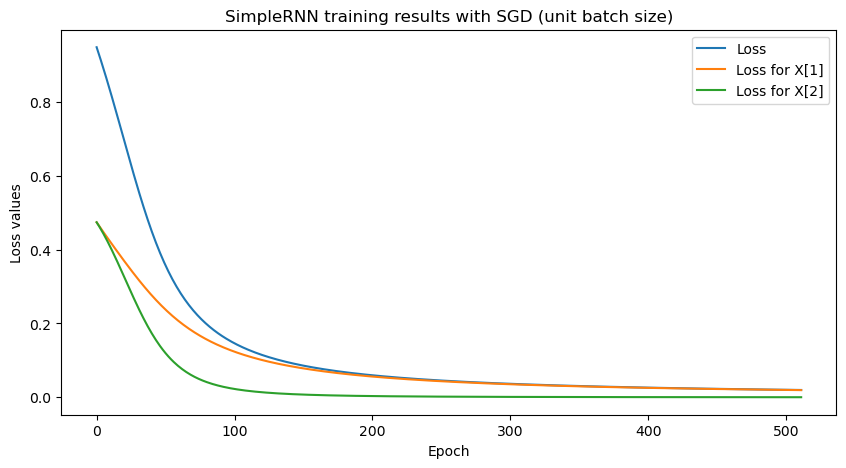

The final weight vector is:     tensor([[ 2.1860, -2.0651]])
The final bias vector is:       tensor([2.8557])
The final scalar v is:          -2.7735


In [7]:
SimpleRNN_Results(loss_values = losses, 
                  loss_t1_values = losses_t1, 
                  losses_t2_values = losses_t2, 
                  weights = weights, 
                  bias = bias, 
                  v = v)

# Exercise 2, b)

## i)

<h2>Investigate what teacher forcing is and explain it in your own words.</h2>
<p>Teacher forcing is a technique that can be implemented in an autoregressive RNN in order to make it converge much faster! In a vanilla autoregressive RNN, where we want to make predictions many time steps to the future, what happens is that the prediction for a certain time step is used as input to predict for the next time step. This means that a vanilla autoregressive RNN uses its own predictions to make more predictions further into the future. That being said, because a prediction never hits the mark perfectly, inaccurate data is passed to the next time step, for all time steps in the future to which we want to predict. This makes an autoregressive model learn slower because it needs to adjust its ealier predictions first, in order to make good predictions further to the future, and for that many forward and backward passes are required. So, in order to help the autoregressive RNN learn faster and with more accurate data, teacher forcing is used, which just means that we use the ground truth from the previous time step as input to the following time step, instead of the prediction from the previous time step.

In this exercise, we have an autoregressive RNN, just like the one on the image bellow, where first we have the warm-up phase in which all the network's inputs are given first, without any predictions produced; after this phase the network's outputs are produced based on the previous outputs, but to start, the input to the first output is the last input given to the model. So, looking at this architecture, we can say that teacher forcing consists of replacing the model's outputs by the labels as the inputs; for example, for t = 25, instead of giving as input the prediction from t = 24 the model will give the label for t = 24.

![Autoregressive RNN](https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_autoregressive.png "Autoregressive RNN")

References: https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c</p>


## ii)

In [8]:
#### THIS IS ONLY FOR THE JUPYTER NOTEBOOK WE'LL SUBMIT

'''# Download the data
import requests
import zipfile
response = requests.get('https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip')
open('weather_dataset.zip', 'wb').write(response.content)
with zipfile.ZipFile('weather_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
df = pd.read_csv('jena_climate_2009_2016.csv')'''

"# Download the data\nimport requests\nimport zipfile\nresponse = requests.get('https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip')\nopen('weather_dataset.zip', 'wb').write(response.content)\nwith zipfile.ZipFile('weather_dataset.zip', 'r') as zip_ref:\n    zip_ref.extractall('./')\ndf = pd.read_csv('jena_climate_2009_2016.csv')"

In [9]:
# Download the data
df = pd.read_csv('data/jena_climate_2009_2016.csv')

In [10]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# Remove invalid values
wv = df['wv (m/s)']
bad_wv = (wv == -9999.0)
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = (max_wv == -9999.0)
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

# Build wind vector
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [12]:
INPUT_WIDTH = 24
TARGET_WIDTH = 24

train_data = WeatherData(train_df, INPUT_WIDTH, TARGET_WIDTH)
val_data = WeatherData(val_df, INPUT_WIDTH, TARGET_WIDTH)
test_data = WeatherData(test_df, INPUT_WIDTH, TARGET_WIDTH)

In [13]:
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-4
NUM_EPOCHS = 64
BATCH_SIZE = 16

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = WeatherPredictor(train_data[0]['inputs'].shape[1], HIDDEN_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

DEVICE: mps


In [14]:
train_loss, val_loss = fit(model, train_loader, val_loader, optimizer, num_epochs = NUM_EPOCHS, device = DEVICE)

Epoch 1/64
Training phase...


loss = 0.384: 100%|██████████| 128/128 [00:13<00:00,  9.61it/s]


train loss = 0.680
Validation phase...


loss = 0.488: 100%|██████████| 37/37 [00:01<00:00, 27.82it/s]


validation loss = 0.591
Epoch 2/64
Training phase...


loss = 0.131: 100%|██████████| 128/128 [00:13<00:00,  9.76it/s]


train loss = 0.290
Validation phase...


loss = 0.243: 100%|██████████| 37/37 [00:01<00:00, 28.86it/s]


validation loss = 0.322
Epoch 3/64
Training phase...


loss = 0.129: 100%|██████████| 128/128 [00:13<00:00,  9.71it/s]


train loss = 0.138
Validation phase...


loss = 0.266: 100%|██████████| 37/37 [00:01<00:00, 28.77it/s]


validation loss = 0.286
Epoch 4/64
Training phase...


loss = 0.136: 100%|██████████| 128/128 [00:13<00:00,  9.75it/s]


train loss = 0.105
Validation phase...


loss = 0.250: 100%|██████████| 37/37 [00:01<00:00, 28.44it/s]


validation loss = 0.260
Epoch 5/64
Training phase...


loss = 0.087: 100%|██████████| 128/128 [00:13<00:00,  9.76it/s]


train loss = 0.091
Validation phase...


loss = 0.225: 100%|██████████| 37/37 [00:01<00:00, 28.69it/s]


validation loss = 0.247
Epoch 6/64
Training phase...


loss = 0.084: 100%|██████████| 128/128 [00:13<00:00,  9.57it/s]


train loss = 0.084
Validation phase...


loss = 0.208: 100%|██████████| 37/37 [00:01<00:00, 28.87it/s]


validation loss = 0.250
Epoch 7/64
Training phase...


loss = 0.066: 100%|██████████| 128/128 [00:12<00:00,  9.87it/s]


train loss = 0.079
Validation phase...


loss = 0.196: 100%|██████████| 37/37 [00:01<00:00, 27.16it/s]


validation loss = 0.246
Epoch 8/64
Training phase...


loss = 0.074: 100%|██████████| 128/128 [00:13<00:00,  9.18it/s]


train loss = 0.075
Validation phase...


loss = 0.238: 100%|██████████| 37/37 [00:01<00:00, 28.96it/s]


validation loss = 0.236
Epoch 9/64
Training phase...


loss = 0.046: 100%|██████████| 128/128 [00:13<00:00,  9.47it/s]


train loss = 0.073
Validation phase...


loss = 0.194: 100%|██████████| 37/37 [00:01<00:00, 27.89it/s]


validation loss = 0.246
Epoch 10/64
Training phase...


loss = 0.065: 100%|██████████| 128/128 [00:13<00:00,  9.78it/s]


train loss = 0.071
Validation phase...


loss = 0.177: 100%|██████████| 37/37 [00:01<00:00, 28.41it/s]


validation loss = 0.242
Epoch 11/64
Training phase...


loss = 0.059: 100%|██████████| 128/128 [00:13<00:00,  9.59it/s]


train loss = 0.070
Validation phase...


loss = 0.189: 100%|██████████| 37/37 [00:01<00:00, 28.93it/s]


validation loss = 0.232
Epoch 12/64
Training phase...


loss = 0.054: 100%|██████████| 128/128 [00:13<00:00,  9.83it/s]


train loss = 0.069
Validation phase...


loss = 0.191: 100%|██████████| 37/37 [00:01<00:00, 28.72it/s]


validation loss = 0.227
Epoch 13/64
Training phase...


loss = 0.077: 100%|██████████| 128/128 [00:13<00:00,  9.82it/s]


train loss = 0.068
Validation phase...


loss = 0.178: 100%|██████████| 37/37 [00:01<00:00, 29.12it/s]


validation loss = 0.237
Epoch 14/64
Training phase...


loss = 0.085: 100%|██████████| 128/128 [00:12<00:00,  9.89it/s]


train loss = 0.067
Validation phase...


loss = 0.202: 100%|██████████| 37/37 [00:01<00:00, 29.31it/s]


validation loss = 0.234
Epoch 15/64
Training phase...


loss = 0.066: 100%|██████████| 128/128 [00:12<00:00,  9.85it/s]


train loss = 0.067
Validation phase...


loss = 0.197: 100%|██████████| 37/37 [00:01<00:00, 28.67it/s]


validation loss = 0.227
Epoch 16/64
Training phase...


loss = 0.077: 100%|██████████| 128/128 [00:13<00:00,  9.37it/s]


train loss = 0.066
Validation phase...


loss = 0.199: 100%|██████████| 37/37 [00:01<00:00, 28.66it/s]


validation loss = 0.227
Epoch 17/64
Training phase...


loss = 0.056: 100%|██████████| 128/128 [00:13<00:00,  9.73it/s]


train loss = 0.066
Validation phase...


loss = 0.198: 100%|██████████| 37/37 [00:01<00:00, 28.82it/s]


validation loss = 0.235
Epoch 18/64
Training phase...


loss = 0.067: 100%|██████████| 128/128 [00:13<00:00,  9.75it/s]


train loss = 0.066
Validation phase...


loss = 0.206: 100%|██████████| 37/37 [00:01<00:00, 28.55it/s]


validation loss = 0.227
Epoch 19/64
Training phase...


loss = 0.048: 100%|██████████| 128/128 [00:13<00:00,  9.53it/s]


train loss = 0.065
Validation phase...


loss = 0.240: 100%|██████████| 37/37 [00:01<00:00, 28.59it/s]


validation loss = 0.237
Epoch 20/64
Training phase...


loss = 0.062: 100%|██████████| 128/128 [00:13<00:00,  9.50it/s]


train loss = 0.065
Validation phase...


loss = 0.190: 100%|██████████| 37/37 [00:01<00:00, 28.53it/s]


validation loss = 0.226
Epoch 21/64
Training phase...


loss = 0.063: 100%|██████████| 128/128 [00:13<00:00,  9.71it/s]


train loss = 0.065
Validation phase...


loss = 0.220: 100%|██████████| 37/37 [00:01<00:00, 28.51it/s]


validation loss = 0.229
Epoch 22/64
Training phase...


loss = 0.071: 100%|██████████| 128/128 [00:13<00:00,  9.70it/s]


train loss = 0.064
Validation phase...


loss = 0.212: 100%|██████████| 37/37 [00:01<00:00, 28.54it/s]


validation loss = 0.224
Epoch 23/64
Training phase...


loss = 0.049: 100%|██████████| 128/128 [00:13<00:00,  9.47it/s]


train loss = 0.064
Validation phase...


loss = 0.239: 100%|██████████| 37/37 [00:01<00:00, 28.21it/s]


validation loss = 0.235
Epoch 24/64
Training phase...


loss = 0.060: 100%|██████████| 128/128 [00:13<00:00,  9.54it/s]


train loss = 0.064
Validation phase...


loss = 0.186: 100%|██████████| 37/37 [00:01<00:00, 28.04it/s]


validation loss = 0.224
Epoch 25/64
Training phase...


loss = 0.082: 100%|██████████| 128/128 [00:13<00:00,  9.56it/s]


train loss = 0.064
Validation phase...


loss = 0.212: 100%|██████████| 37/37 [00:01<00:00, 27.78it/s]


validation loss = 0.237
Epoch 26/64
Training phase...


loss = 0.067: 100%|██████████| 128/128 [00:13<00:00,  9.52it/s]


train loss = 0.064
Validation phase...


loss = 0.208: 100%|██████████| 37/37 [00:01<00:00, 28.16it/s]


validation loss = 0.234
Epoch 27/64
Training phase...


loss = 0.069: 100%|██████████| 128/128 [00:13<00:00,  9.56it/s]


train loss = 0.063
Validation phase...


loss = 0.264: 100%|██████████| 37/37 [00:01<00:00, 28.57it/s]


validation loss = 0.231
Epoch 28/64
Training phase...


loss = 0.066: 100%|██████████| 128/128 [00:13<00:00,  9.57it/s]


train loss = 0.063
Validation phase...


loss = 0.200: 100%|██████████| 37/37 [00:01<00:00, 28.44it/s]


validation loss = 0.217
Epoch 29/64
Training phase...


loss = 0.047: 100%|██████████| 128/128 [00:13<00:00,  9.49it/s]


train loss = 0.063
Validation phase...


loss = 0.278: 100%|██████████| 37/37 [00:01<00:00, 27.86it/s]


validation loss = 0.240
Epoch 30/64
Training phase...


loss = 0.072: 100%|██████████| 128/128 [00:13<00:00,  9.58it/s]


train loss = 0.063
Validation phase...


loss = 0.219: 100%|██████████| 37/37 [00:01<00:00, 28.28it/s]


validation loss = 0.236
Epoch 31/64
Training phase...


loss = 0.062: 100%|██████████| 128/128 [00:13<00:00,  9.54it/s]


train loss = 0.063
Validation phase...


loss = 0.213: 100%|██████████| 37/37 [00:01<00:00, 27.97it/s]


validation loss = 0.226
Epoch 32/64
Training phase...


loss = 0.061: 100%|██████████| 128/128 [00:13<00:00,  9.30it/s]


train loss = 0.063
Validation phase...


loss = 0.218: 100%|██████████| 37/37 [00:01<00:00, 28.54it/s]


validation loss = 0.234
Epoch 33/64
Training phase...


loss = 0.052: 100%|██████████| 128/128 [00:13<00:00,  9.39it/s]


train loss = 0.062
Validation phase...


loss = 0.223: 100%|██████████| 37/37 [00:01<00:00, 29.06it/s]


validation loss = 0.228
Epoch 34/64
Training phase...


loss = 0.073: 100%|██████████| 128/128 [00:13<00:00,  9.76it/s]


train loss = 0.062
Validation phase...


loss = 0.201: 100%|██████████| 37/37 [00:01<00:00, 27.27it/s]


validation loss = 0.229
Epoch 35/64
Training phase...


loss = 0.059: 100%|██████████| 128/128 [00:13<00:00,  9.61it/s]


train loss = 0.062
Validation phase...


loss = 0.223: 100%|██████████| 37/37 [00:01<00:00, 28.19it/s]


validation loss = 0.238
Epoch 36/64
Training phase...


loss = 0.055: 100%|██████████| 128/128 [00:13<00:00,  9.68it/s]


train loss = 0.062
Validation phase...


loss = 0.230: 100%|██████████| 37/37 [00:01<00:00, 29.17it/s]


validation loss = 0.252
Epoch 37/64
Training phase...


loss = 0.060: 100%|██████████| 128/128 [00:13<00:00,  9.76it/s]


train loss = 0.062
Validation phase...


loss = 0.241: 100%|██████████| 37/37 [00:01<00:00, 28.32it/s]


validation loss = 0.244
Epoch 38/64
Training phase...


loss = 0.069: 100%|██████████| 128/128 [00:13<00:00,  9.75it/s]


train loss = 0.062
Validation phase...


loss = 0.190: 100%|██████████| 37/37 [00:01<00:00, 29.16it/s]


validation loss = 0.229
Epoch 39/64
Training phase...


loss = 0.040: 100%|██████████| 128/128 [00:13<00:00,  9.64it/s]


train loss = 0.062
Validation phase...


loss = 0.223: 100%|██████████| 37/37 [00:01<00:00, 28.95it/s]


validation loss = 0.233
Epoch 40/64
Training phase...


loss = 0.049: 100%|██████████| 128/128 [00:12<00:00,  9.87it/s]


train loss = 0.062
Validation phase...


loss = 0.264: 100%|██████████| 37/37 [00:01<00:00, 29.05it/s]


validation loss = 0.230
Epoch 41/64
Training phase...


loss = 0.080: 100%|██████████| 128/128 [00:13<00:00,  9.82it/s]


train loss = 0.062
Validation phase...


loss = 0.206: 100%|██████████| 37/37 [00:01<00:00, 28.41it/s]


validation loss = 0.228
Epoch 42/64
Training phase...


loss = 0.057: 100%|██████████| 128/128 [00:13<00:00,  9.60it/s]


train loss = 0.062
Validation phase...


loss = 0.240: 100%|██████████| 37/37 [00:01<00:00, 29.26it/s]


validation loss = 0.233
Epoch 43/64
Training phase...


loss = 0.058: 100%|██████████| 128/128 [00:13<00:00,  9.75it/s]


train loss = 0.062
Validation phase...


loss = 0.212: 100%|██████████| 37/37 [00:01<00:00, 28.27it/s]


validation loss = 0.221
Epoch 44/64
Training phase...


loss = 0.038: 100%|██████████| 128/128 [00:13<00:00,  9.62it/s]


train loss = 0.061
Validation phase...


loss = 0.253: 100%|██████████| 37/37 [00:01<00:00, 28.75it/s]


validation loss = 0.248
Epoch 45/64
Training phase...


loss = 0.055: 100%|██████████| 128/128 [00:13<00:00,  9.67it/s]


train loss = 0.061
Validation phase...


loss = 0.246: 100%|██████████| 37/37 [00:01<00:00, 28.53it/s]


validation loss = 0.238
Epoch 46/64
Training phase...


loss = 0.047: 100%|██████████| 128/128 [00:13<00:00,  9.70it/s]


train loss = 0.061
Validation phase...


loss = 0.220: 100%|██████████| 37/37 [00:01<00:00, 29.60it/s]


validation loss = 0.233
Epoch 47/64
Training phase...


loss = 0.053: 100%|██████████| 128/128 [00:13<00:00,  9.68it/s]


train loss = 0.061
Validation phase...


loss = 0.229: 100%|██████████| 37/37 [00:01<00:00, 27.72it/s]


validation loss = 0.224
Epoch 48/64
Training phase...


loss = 0.081: 100%|██████████| 128/128 [00:13<00:00,  9.65it/s]


train loss = 0.061
Validation phase...


loss = 0.216: 100%|██████████| 37/37 [00:01<00:00, 28.92it/s]


validation loss = 0.237
Epoch 49/64
Training phase...


loss = 0.078: 100%|██████████| 128/128 [00:13<00:00,  9.69it/s]


train loss = 0.061
Validation phase...


loss = 0.211: 100%|██████████| 37/37 [00:01<00:00, 29.36it/s]


validation loss = 0.235
Epoch 50/64
Training phase...


loss = 0.064: 100%|██████████| 128/128 [00:13<00:00,  9.66it/s]


train loss = 0.061
Validation phase...


loss = 0.194: 100%|██████████| 37/37 [00:01<00:00, 29.32it/s]


validation loss = 0.252
Epoch 51/64
Training phase...


loss = 0.039: 100%|██████████| 128/128 [00:13<00:00,  9.60it/s]


train loss = 0.061
Validation phase...


loss = 0.202: 100%|██████████| 37/37 [00:01<00:00, 29.57it/s]


validation loss = 0.234
Epoch 52/64
Training phase...


loss = 0.062: 100%|██████████| 128/128 [00:13<00:00,  9.78it/s]


train loss = 0.061
Validation phase...


loss = 0.222: 100%|██████████| 37/37 [00:01<00:00, 28.94it/s]


validation loss = 0.231
Epoch 53/64
Training phase...


loss = 0.049: 100%|██████████| 128/128 [00:13<00:00,  9.59it/s]


train loss = 0.061
Validation phase...


loss = 0.248: 100%|██████████| 37/37 [00:01<00:00, 28.97it/s]


validation loss = 0.241
Epoch 54/64
Training phase...


loss = 0.052: 100%|██████████| 128/128 [00:12<00:00,  9.88it/s]


train loss = 0.061
Validation phase...


loss = 0.251: 100%|██████████| 37/37 [00:01<00:00, 29.02it/s]


validation loss = 0.261
Epoch 55/64
Training phase...


loss = 0.040: 100%|██████████| 128/128 [00:13<00:00,  9.68it/s]


train loss = 0.061
Validation phase...


loss = 0.216: 100%|██████████| 37/37 [00:01<00:00, 28.89it/s]


validation loss = 0.240
Epoch 56/64
Training phase...


loss = 0.084: 100%|██████████| 128/128 [00:13<00:00,  9.69it/s]


train loss = 0.061
Validation phase...


loss = 0.245: 100%|██████████| 37/37 [00:01<00:00, 28.48it/s]


validation loss = 0.230
Epoch 57/64
Training phase...


loss = 0.060: 100%|██████████| 128/128 [00:13<00:00,  9.80it/s]


train loss = 0.061
Validation phase...


loss = 0.233: 100%|██████████| 37/37 [00:01<00:00, 28.44it/s]


validation loss = 0.229
Epoch 58/64
Training phase...


loss = 0.074: 100%|██████████| 128/128 [00:13<00:00,  9.74it/s]


train loss = 0.061
Validation phase...


loss = 0.203: 100%|██████████| 37/37 [00:01<00:00, 28.50it/s]


validation loss = 0.256
Epoch 59/64
Training phase...


loss = 0.065: 100%|██████████| 128/128 [00:13<00:00,  9.66it/s]


train loss = 0.061
Validation phase...


loss = 0.272: 100%|██████████| 37/37 [00:01<00:00, 28.61it/s]


validation loss = 0.238
Epoch 60/64
Training phase...


loss = 0.061: 100%|██████████| 128/128 [00:13<00:00,  9.71it/s]


train loss = 0.060
Validation phase...


loss = 0.194: 100%|██████████| 37/37 [00:01<00:00, 29.36it/s]


validation loss = 0.241
Epoch 61/64
Training phase...


loss = 0.056: 100%|██████████| 128/128 [00:13<00:00,  9.68it/s]


train loss = 0.060
Validation phase...


loss = 0.297: 100%|██████████| 37/37 [00:01<00:00, 29.06it/s]


validation loss = 0.245
Epoch 62/64
Training phase...


loss = 0.065: 100%|██████████| 128/128 [00:13<00:00,  9.70it/s]


train loss = 0.060
Validation phase...


loss = 0.238: 100%|██████████| 37/37 [00:01<00:00, 29.23it/s]


validation loss = 0.233
Epoch 63/64
Training phase...


loss = 0.057: 100%|██████████| 128/128 [00:13<00:00,  9.62it/s]


train loss = 0.060
Validation phase...


loss = 0.222: 100%|██████████| 37/37 [00:01<00:00, 29.36it/s]


validation loss = 0.231
Epoch 64/64
Training phase...


loss = 0.078: 100%|██████████| 128/128 [00:13<00:00,  9.67it/s]


train loss = 0.060
Validation phase...


loss = 0.221: 100%|██████████| 37/37 [00:01<00:00, 28.74it/s]

validation loss = 0.237


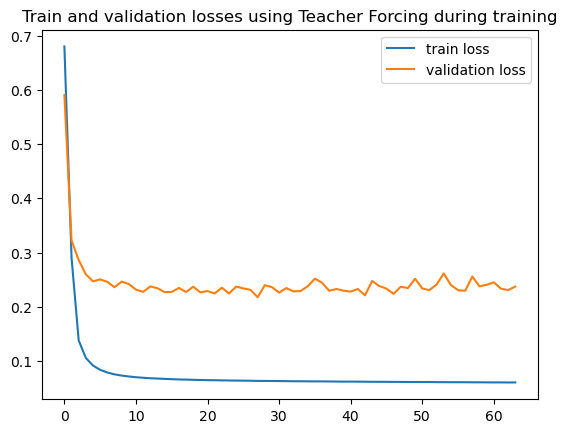

In [15]:
plt.title('Train and validation losses using Teacher Forcing during training')
plt.plot(range(len(train_loss)), train_loss, label='train loss')
plt.plot(range(len(val_loss)), val_loss, label='validation loss')
plt.legend()
plt.show()

## iii)

<h2>Which of the strategies do you expect to yield a model with better generalization? Explain your answer.</h2>
<p>The strategy that enables to model to generalize better for unseen sequences would the a RNN without teacher forcing. Altough teacher forcing enables a RNN to converge quicker to a local optimum, the disadvantage is that when facing unseen data (development and testing sets), an autoregressive model has no way of knowing what is the ground truth for a particular time step, and therefore underperforms with a high variance (or overfit). So, if a RNN w/teacher forcing is more likely to underperform when faced with unsees data than an autoregressive RNN that learns with only what it knows, then a model without teacher forcing generalizes better!</p>